In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D, Reshape, InputLayer, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, CSVLogger
from keras.models import Sequential, load_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import clone_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import argparse
import pickle
import keras
import os
import gc

In [2]:
data_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\DataSet"
results_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\New Results"
model_info_path = os.path.join(results_path,'model info')
images_path = os.path.join(results_path, "images")

model_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\Activity-Recognition-from-Single-Chest-Mounted-Accelerometer-master\\neural_network_model.h5"
model = keras.models.load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
Total params: 694,152
Trainable params: 694,152
Non-trainable params: 0
_________________________________________________________________


In [3]:
plot_model(model, to_file= os.path.join(model_path, "model_name"+'.png'), show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


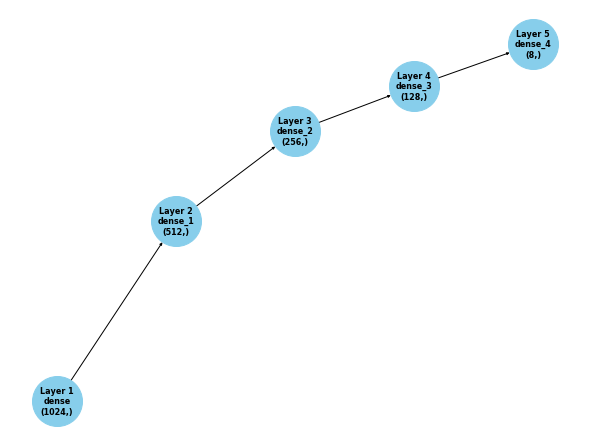

In [4]:
def plot_neural_network(model):
    G = nx.DiGraph()
    for i, layer in enumerate(model.layers):
        G.add_node(f'Layer {i + 1}\n{layer.name}\n{layer.output_shape[1:]}')
    for i in range(len(model.layers) - 1):
        for node1 in G.nodes:
            if node1.startswith(f'Layer {i + 1}'):
                for node2 in G.nodes:
                    if node2.startswith(f'Layer {i + 2}'):
                        G.add_edge(node1, node2)
    pos = {}
    for i, layer in enumerate(model.layers):
        pos[f'Layer {i + 1}\n{layer.name}\n{layer.output_shape[1:]}'] = (i, -layer.output_shape[1])
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=2500, node_color='skyblue', font_color='black', font_size=8, arrowsize=5)
    plt.show()
plot_neural_network(model)

In [5]:
input_shape = model.layers[0].input_shape
print("Input shape:", input_shape)
input_size = input_shape[1:]
print("Input size:", input_size)

output_shape = model.layers[-1].output_shape
print("Output shape:", output_shape)
output_size = output_shape[1:]
print("Output size:", output_size)

Input shape: (None, 3)
Input size: (3,)
Output shape: (None, 8)
Output size: (8,)


In [6]:
def save_object(obj, filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
    
def load_object(filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [7]:
train = pd.read_csv(os.path.join(data_path,"train.csv"))
test = pd.read_csv(os.path.join(data_path,"test.csv"))

X_train = train.drop('Activity', axis=1)
X_test = test.drop('Activity', axis=1)
y_train = np.array(train['Activity'].tolist())
y_test = np.array(test['Activity'].tolist())
num_classes = len(set(y_test))  # Number of classes
print(num_classes)

6


In [8]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_encoded = to_categorical(y_train_encoded, num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes)

num_features = X_train.shape[1]
timesteps = 1

X_train_reshaped = X_train.values.reshape(-1, num_features)
X_test_reshaped = X_test.values.reshape(-1, num_features)
save_object(label_encoder, "label_encoder",results_path)

In [9]:
def plot_history(history, title, images_path):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.savefig("{} .png".format(os.path.join(images_path , "history")))
    plt.savefig(os.path.join(images_path, title + '.svg'), format='svg')
    plt.legend()

In [10]:
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
model_name = "FineTunned_Model"
filepath = os.path.join(model_info_path, model_name+'.best.hdf5')
history_logger = CSVLogger(os.path.join(model_info_path,'History.csv'), separator=",", append=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [GarbageCollectorCallback(), checkpoint, es, history_logger]

In [11]:
modified_model = clone_model(model)
Layers = [Dense(1024, input_shape=(timesteps, num_features), activation='relu', name='dense_0')]
for layer in modified_model.layers[1:-1]:
    Layers.append(layer)
Layers.append(Dense(num_classes, activation='softmax', name='dense_4'))
new_model = Sequential(Layers)

# modified_model.layers[0] = Dense(1024, activation='relu', input_shape=(num_features,None,))
# modified_model.layers[-1] = Dense(num_classes, activation='softmax')
# new_layer = InputLayer(input_shape=(num_features,None,))
# modified_model = Sequential([new_layer, *modified_model.layers])

for layer in new_model.layers[1:-1]:
    layer.trainable = False

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 1, 1024)           576512    
_________________________________________________________________
dense_1 (Dense)              multiple                  524800    
_________________________________________________________________
dense_2 (Dense)              multiple                  131328    
_________________________________________________________________
dense_3 (Dense)              multiple                  32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 6)              774       
Total params: 1,266,310
Trainable params: 577,286
Non-trainable params: 689,024
_________________________________________________________________


In [12]:
input_shape = new_model.layers[0].input_shape
print("Input shape:", input_shape)
input_size = input_shape
print("Input size:", input_size)

output_shape = new_model.layers[-1].output_shape
print("Output shape:", output_shape)
output_size = output_shape[1:]
print("Output size:", output_size)


Input shape: (None, 1, 562)
Input size: (None, 1, 562)
Output shape: (None, 1, 6)
Output size: (1, 6)


In [13]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = new_model.fit(X_train_reshaped, y_train_encoded, epochs=500, batch_size=8, validation_split=0.2, verbose=1, shuffle=False, callbacks=callbacks_list)
new_model.save(os.path.join(model_info_path, model_name+".h5"))

Epoch 1/500
736/736 [==============================] - 3s 4ms/step - loss: 1.1505 - accuracy: 0.4275 - val_loss: 0.4701 - val_accuracy: 0.8538
Epoch 2/500
736/736 [==============================] - 3s 4ms/step - loss: 0.5196 - accuracy: 0.7572 - val_loss: 0.4116 - val_accuracy: 0.7995
Epoch 3/500
736/736 [==============================] - 3s 4ms/step - loss: 0.4246 - accuracy: 0.8033 - val_loss: 0.5972 - val_accuracy: 0.7328
Epoch 4/500
736/736 [==============================] - 3s 4ms/step - loss: 0.3516 - accuracy: 0.8420 - val_loss: 0.3337 - val_accuracy: 0.8654
Epoch 5/500
736/736 [==============================] - 3s 4ms/step - loss: 0.3492 - accuracy: 0.8471 - val_loss: 0.2775 - val_accuracy: 0.8885
Epoch 6/500
736/736 [==============================] - 3s 4ms/step - loss: 0.2870 - accuracy: 0.8732 - val_loss: 0.6112 - val_accuracy: 0.7566
Epoch 7/500
736/736 [==============================] - 3s 4ms/step - loss: 0.2969 - accuracy: 0.8660 - val_loss: 0.5210 - val_accuracy: 0.8402

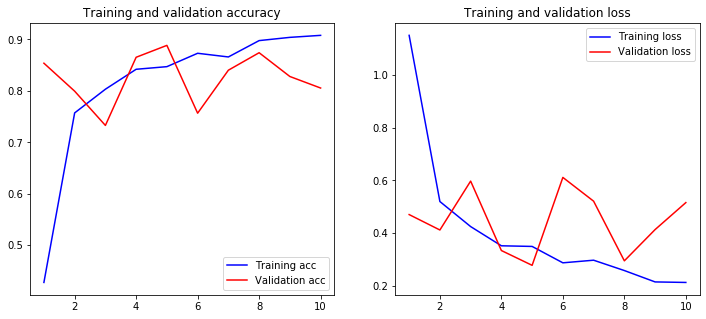

In [14]:
plot_history(history, "Accuracy", images_path)

In [15]:
y_pred = new_model.predict(X_test_reshaped, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)
classification_rep = classification_report(y_test_labels, y_pred_labels)
classes_number = [0, 1, 2, 3, 4, 5]
classes = label_encoder.inverse_transform(classes_number)
print(list(zip(classes, classes_number)))
print(classification_rep)

[('LAYING', 0), ('SITTING', 1), ('STANDING', 2), ('WALKING', 3), ('WALKING_DOWNSTAIRS', 4), ('WALKING_UPSTAIRS', 5)]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       537
           1       0.85      0.68      0.75       491
           2       0.87      0.83      0.85       532
           3       0.95      0.91      0.93       496
           4       0.99      0.78      0.88       420
           5       0.74      1.00      0.85       471

    accuracy                           0.87      2947
   macro avg       0.88      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



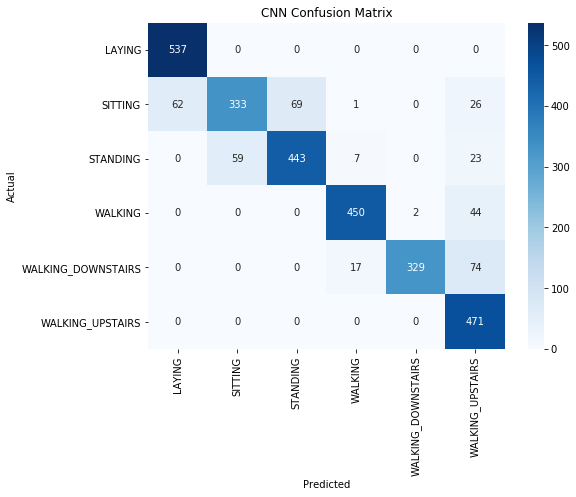

In [16]:
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.savefig("{} .png".format(os.path.join(images_path , 'CNN Confusion Matrix')))
plt.show()